# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1 
data = pd.read_excel('alldata.xlsx')
questionsDR = pd.read_excel('drq.xlsx')
questionsTV = pd.read_excel('tv2q.xlsx')

# Remove rows with age 0 and parti 'Løsgænger' 
data_filtered = data.loc[data['alder'] != 0]
data_filtered = data_filtered.loc[data['parti'] != 'Løsgænger']
data_filtered = data_filtered.dropna()
data_filtered.head()

# Replace parti names with Letters
data_filtered["parti"] = data_filtered["parti"].replace("Socialdemokratiet", "A")
data_filtered["parti"] = data_filtered["parti"].replace("Radikale Venstre", "B")
data_filtered["parti"] = data_filtered["parti"].replace("Det Konservative Folkeparti", "C")
data_filtered["parti"] = data_filtered["parti"].replace("Nye Borgerlige", "D")
data_filtered["parti"] = data_filtered["parti"].replace("Socialistisk Folkeparti", "F")
data_filtered["parti"] = data_filtered["parti"].replace("Liberal Alliance", "I")
data_filtered["parti"] = data_filtered["parti"].replace("Kristendemokraterne", "K")
data_filtered["parti"] = data_filtered["parti"].replace("Moderaterne", "M")
data_filtered["parti"] = data_filtered["parti"].replace("Dansk Folkeparti", "O")
data_filtered["parti"] = data_filtered["parti"].replace("Frie Grønne, Danmarks Nye Venstrefløjsparti", "Q")
data_filtered["parti"] = data_filtered["parti"].replace("Venstre", "V")
data_filtered["parti"] = data_filtered["parti"].replace("Danmarksdemokraterne", "Æ")
data_filtered["parti"] = data_filtered["parti"].replace("Enhedslisten", "Ø")
data_filtered["parti"] = data_filtered["parti"].replace("Alternativet", "Å")

# Assign color to parties
parti_colors = {
    "A": "#ff0000",
    "B": "#4b0082",
    "C": "#aacc00",
    "D": "#006666",
    "F": "#ff00ff",
    "I": "#00bfff",
    "K": "#808080",
    "M": "#6a5acd",
    "O": "#ffff00",
    "Q": "#39ff14",
    "V": "#006699",
    "Æ": "#6699ff",
    "Ø": "#ffa500",
    "Å": "#008000",
}
data_filtered['color'] = data_filtered['parti'].map(parti_colors)

# Assign political position to parties
political_positions = {
    "A": "Centre-left",
    "V": "Centre-right",
    "M": "Centre-right",
    "F": "Left-wing",
    "Æ": "Right-wing",
    "I": "Right-wing",
    "C": "Right-wing",
    "Ø": "Far-left",
    "B": "Centre-left",
    "D": "Far-right",
    "Å": "Centre-left",
    "O": "Far-right",
    "Q": "Centre-left",
    "K": "Centre-right",
}
data_filtered['political_position'] = data_filtered['parti'].map(political_positions)

# Map political positions to numeric values for correlation analysis
position_mapping = {
    "Far-left": -2,
    "Left-wing": -1,
    "Centre-left": -1,
    "Centre-right": 1,
    "Right-wing": 1,
    "Far-right": 2
}
data_filtered['political_position'] = data_filtered['political_position'].map(position_mapping)

# Filter useless columns
questionsDR_filtered = questionsDR[['ID', 'Question', 'ArgumentFor', 'ArgumentAgainst']].copy()
questionsTV_filtered = questionsTV[['id', 'question']].copy()

# Ensure ID columns are clean
questionsDR_filtered['ID'] = questionsDR_filtered['ID'].astype(str).str.strip()
questionsTV_filtered['id'] = questionsTV_filtered['id'].astype(str).str.strip()
questionsTV_filtered.rename(columns={'id': 'ID', 'question': 'Question'}, inplace=True)

# Melt the answers DataFrame to long format
non_answer_columns = ['navn', 'parti', 'storkreds', 'alder', 'color', 'political_position']
data_filtered_melted = data_filtered.melt(id_vars=non_answer_columns, 
                                           var_name='ID', 
                                           value_name='answer')

# Create a consolidated questions DataFrame
questionsDR_cleaned = questionsDR_filtered[['ID', 'Question']]
questionsTV_cleaned = questionsTV_filtered[['ID', 'Question']]

# Concatenate questions from both sources
merged_questions = pd.concat(
    [questionsDR_cleaned, questionsTV_cleaned],
    ignore_index=True
).drop_duplicates(subset=['ID'], keep='first')

# Merge answers with consolidated questions using outer join
merged_data = pd.merge(data_filtered_melted, merged_questions, on='ID', how='outer')

# Drop rows with NaN values in 'Question' and 'answer'
merged_data = merged_data.dropna(subset=['answer', 'Question'])

# Convert answer to numeric
merged_data['answer'] = pd.to_numeric(merged_data['answer'], errors='coerce')


- An analysis/description of which questions are most crucial concerning their placement on the axes.

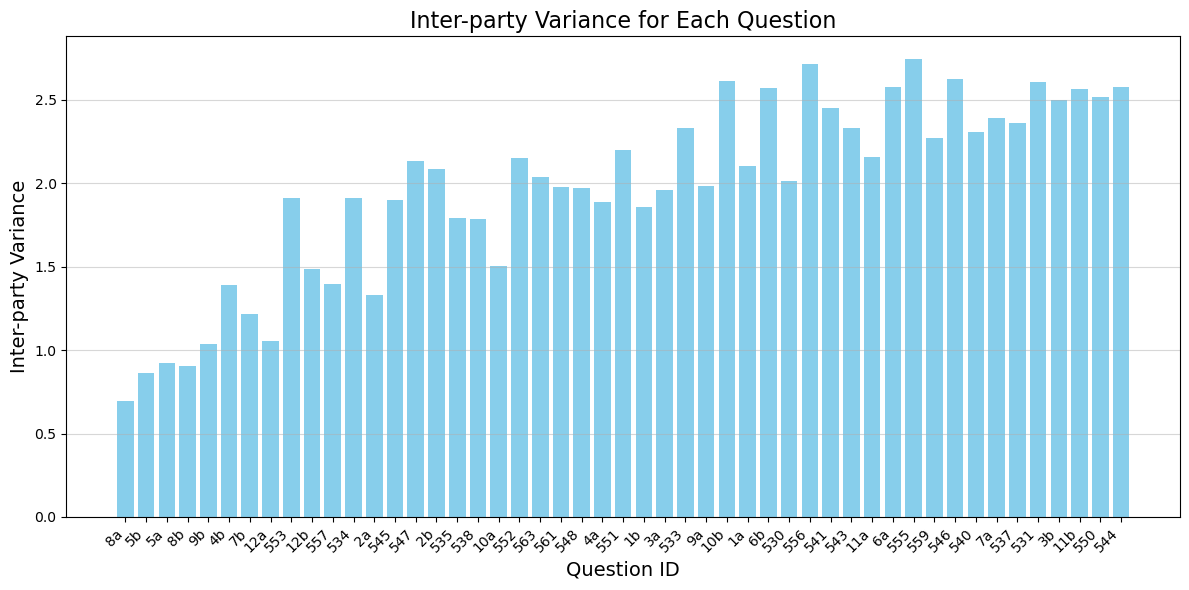

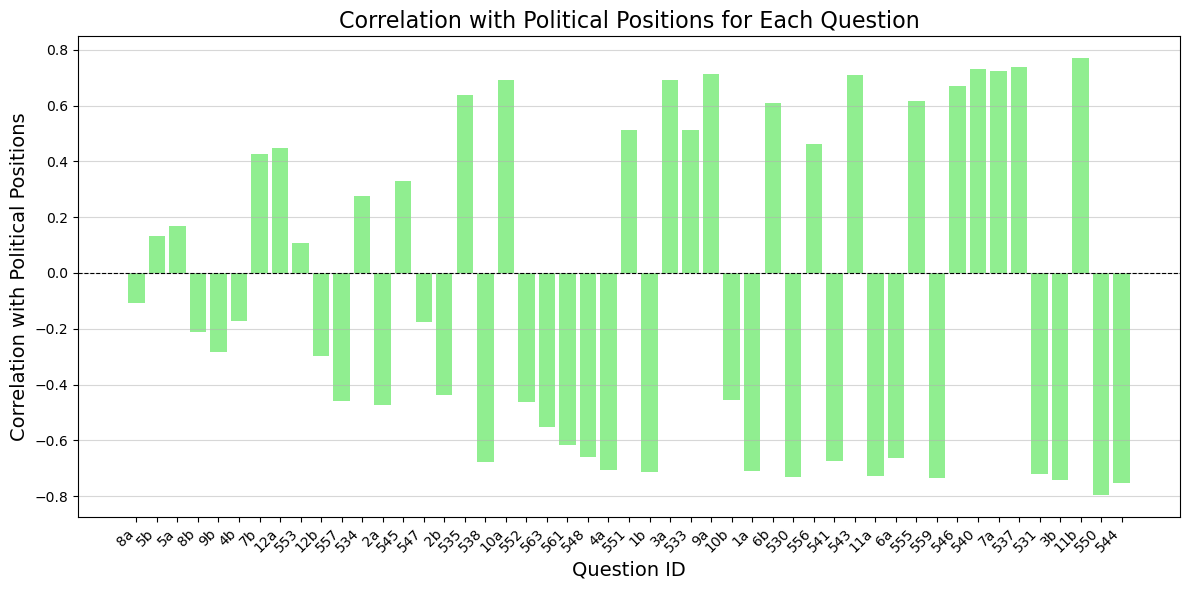

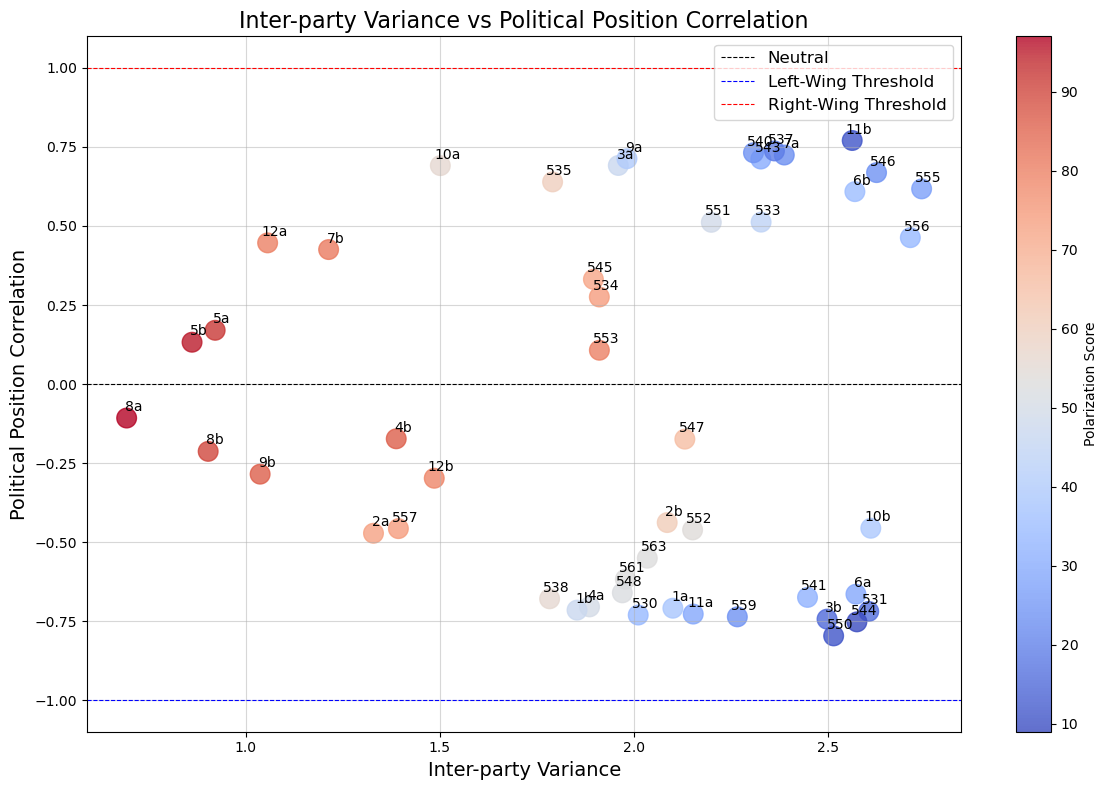

In [173]:
# Calculate inter-party variance for each question
question_variance = merged_data.groupby('ID')['answer'].var().reset_index()
question_variance.rename(columns={'answer': 'inter_party_variance'}, inplace=True)

# Calculate mean answer per question by political position
position_mean_answers = merged_data.groupby(['ID', 'political_position'])['answer'].mean().unstack()

# Calculate correlation between answers and political positions
correlations = []
for question_id, group in merged_data.groupby('ID'):
    correlation = np.corrcoef(group['answer'], group['political_position'])[0, 1]
    correlations.append((question_id, correlation))


# Create a DataFrame for correlations
correlation_df = pd.DataFrame(correlations, columns=['ID', 'political_position'])

# Combine variance and correlation into one DataFrame
question_analysis = pd.merge(question_variance, correlation_df, on='ID')

# Rank questions by inter-party variance and correlation
question_analysis['polarization_score'] = (
    question_analysis['inter_party_variance'].rank(ascending=False) +
    question_analysis['political_position'].abs().rank(ascending=False)
)

# Sort by polarization score
question_analysis_sorted = question_analysis.sort_values('polarization_score', ascending=False)

# Display top questions
top_questions = pd.merge(
    question_analysis_sorted.head(10),
    merged_questions,
    on='ID'
)[['ID', 'Question', 'inter_party_variance', 'political_position', 'polarization_score']]


# 1. Plot inter-party variance for each question
plt.figure(figsize=(12, 6))
plt.bar(
    question_analysis_sorted['ID'],
    question_analysis_sorted['inter_party_variance'],
    color='skyblue'
)
plt.title("Inter-party Variance for Each Question", fontsize=16)
plt.xlabel("Question ID", fontsize=14)
plt.ylabel("Inter-party Variance", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Plot correlation with political positions for each question
plt.figure(figsize=(12, 6))
plt.bar(
    question_analysis_sorted['ID'],
    question_analysis_sorted['political_position'],
    color='lightgreen'
)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Correlation with Political Positions for Each Question", fontsize=16)
plt.xlabel("Question ID", fontsize=14)
plt.ylabel("Correlation with Political Positions", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Combined scatter plot showing polarization and axes positions explicitly
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    question_analysis_sorted['inter_party_variance'],
    question_analysis_sorted['political_position'],
    c=question_analysis_sorted['polarization_score'],
    cmap='coolwarm',
    s=200,
    alpha=0.8
)

# Add a color bar for polarization score
plt.colorbar(scatter, label="Polarization Score")

# Annotate points with question IDs
for i, row in question_analysis_sorted.iterrows():
    plt.annotate(
        row['ID'],
        (row['inter_party_variance'], row['political_position']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=10,
        color='black'
    )

# Plot aesthetics with ideological axis markers
plt.title("Inter-party Variance vs Political Position Correlation", fontsize=16)
plt.xlabel("Inter-party Variance", fontsize=14)
plt.ylabel("Political Position Correlation", fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label="Neutral")
plt.axhline(-1, color='blue', linestyle='--', linewidth=0.8, label="Left-Wing Threshold")
plt.axhline(1, color='red', linestyle='--', linewidth=0.8, label="Right-Wing Threshold")
plt.legend(loc="upper right", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.

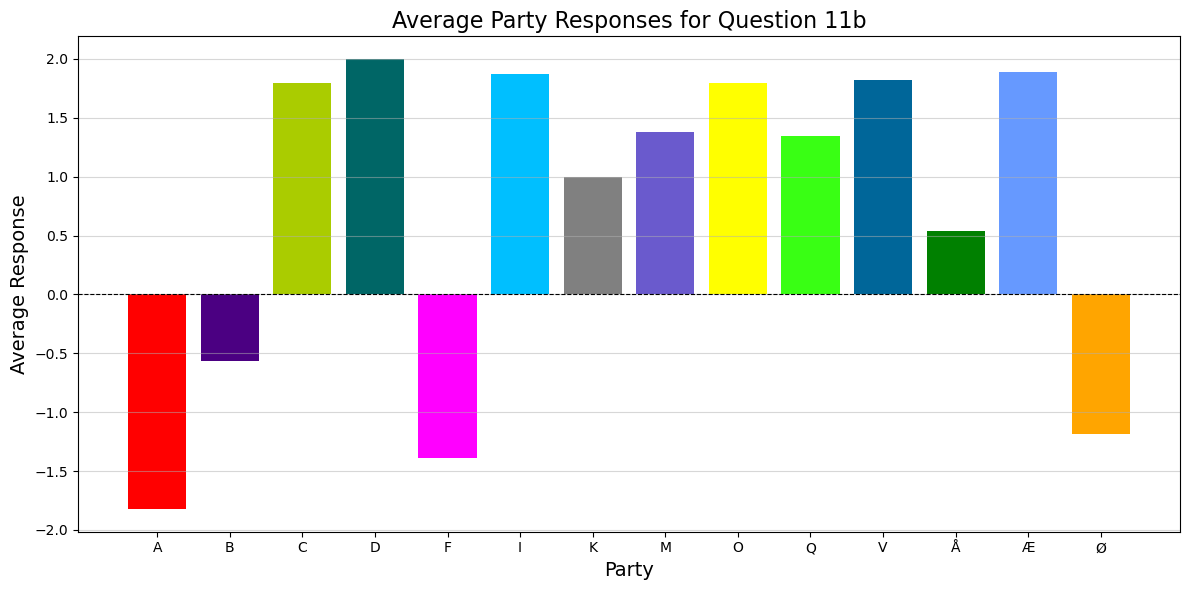

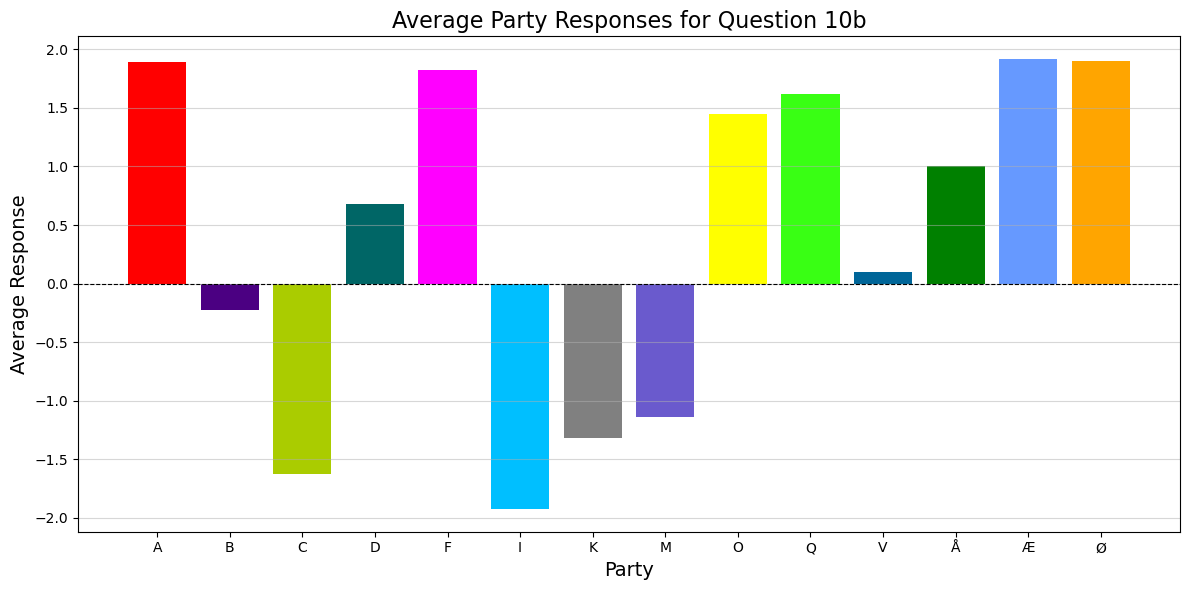

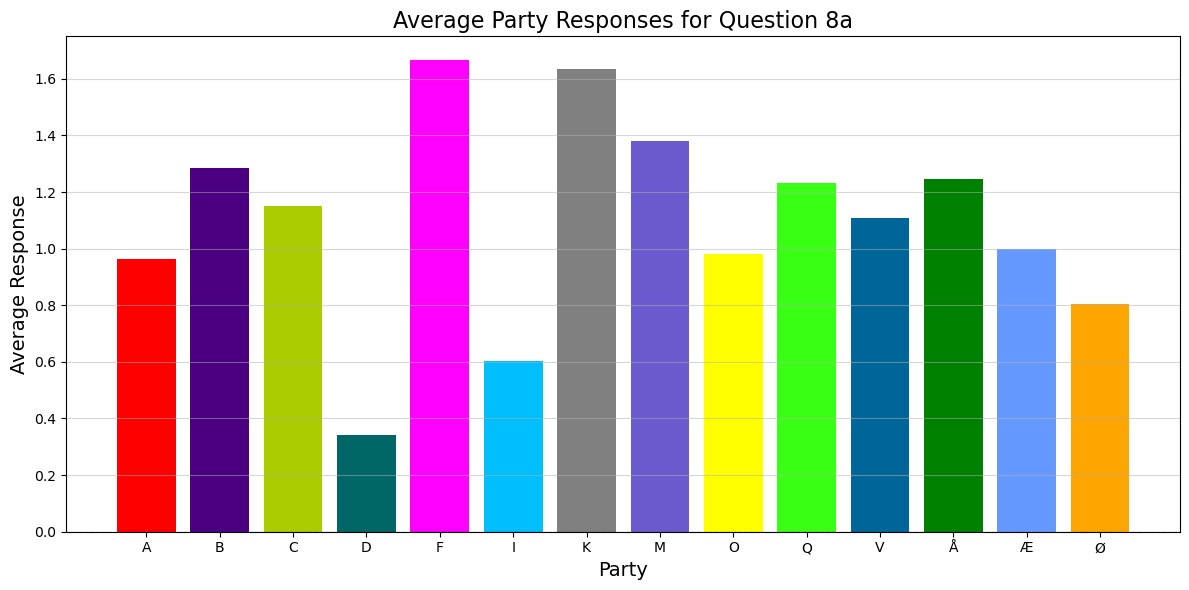

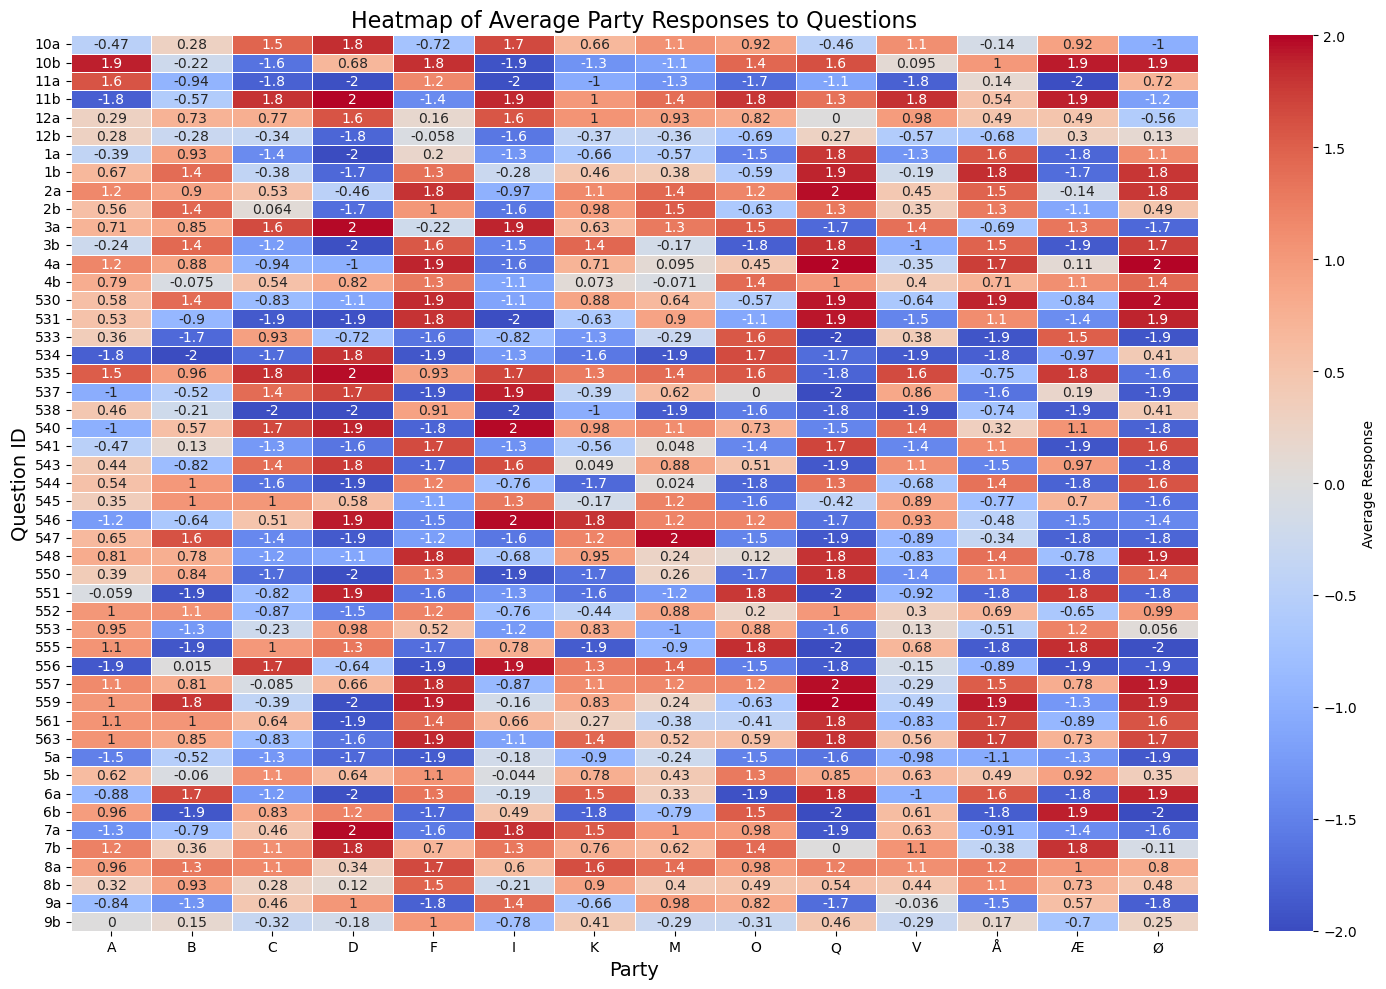

In [174]:
# Calculate average responses of parties for each question
average_positions = merged_data.groupby(['ID', 'parti'])['answer'].mean().unstack()

# Select a few example questions for detailed visualization (e.g., top polarizing questions)
selected_questions = ['11b', '10b', '8a']  # Replace with actual question IDs you want to focus on

# Plot average positions of parties for each selected question
for question_id in selected_questions:
    plt.figure(figsize=(12, 6))
    averages = average_positions.loc[question_id].dropna()
    colors = [parti_colors.get(party, "#000000") for party in averages.index]

    plt.bar(averages.index, averages, color=colors)
    plt.title(f"Average Party Responses for Question {question_id}", fontsize=16)
    plt.xlabel("Party", fontsize=14)
    plt.ylabel("Average Response", fontsize=14)
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.grid(axis="y", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Heatmap: All questions and parties
plt.figure(figsize=(15, 10))
sns.heatmap(
    average_positions,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Average Response'}
)
plt.title("Heatmap of Average Party Responses to Questions", fontsize=16)
plt.xlabel("Party", fontsize=14)
plt.ylabel("Question ID", fontsize=14)
plt.tight_layout()
plt.show()

- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**

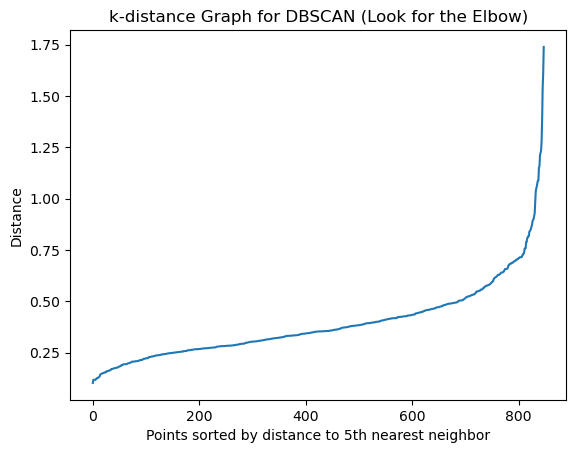

c:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

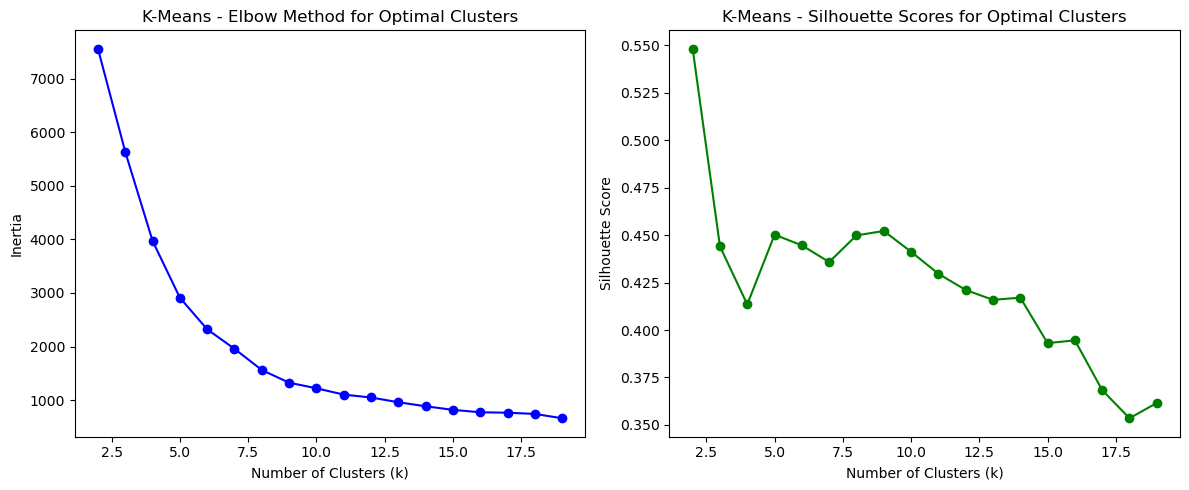

c:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



K-Means Clustering Evaluation:
Silhouette Score: 0.4433

Hierarchical Clustering Evaluation:
Silhouette Score: 0.4290


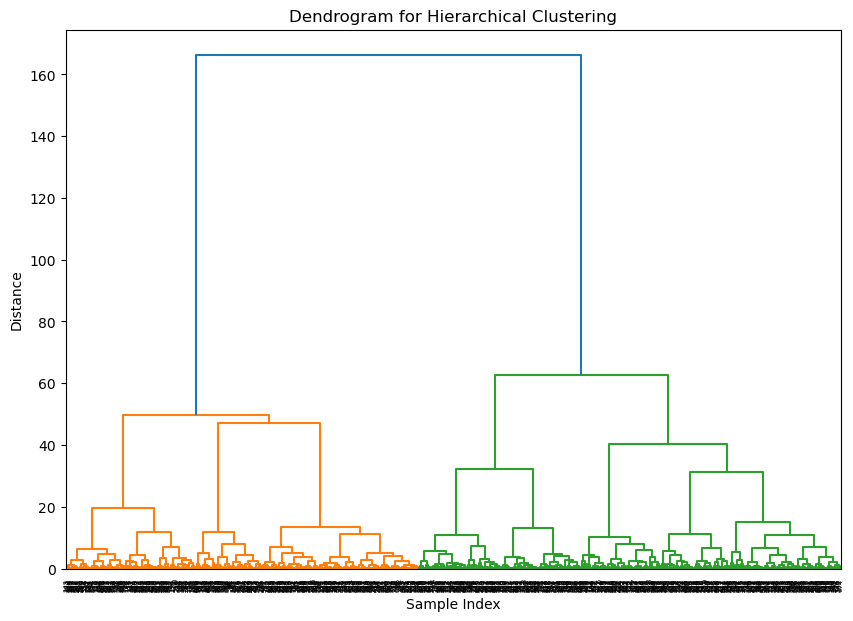


DBSCAN Clustering Evaluation:
Silhouette Score: 0.4586


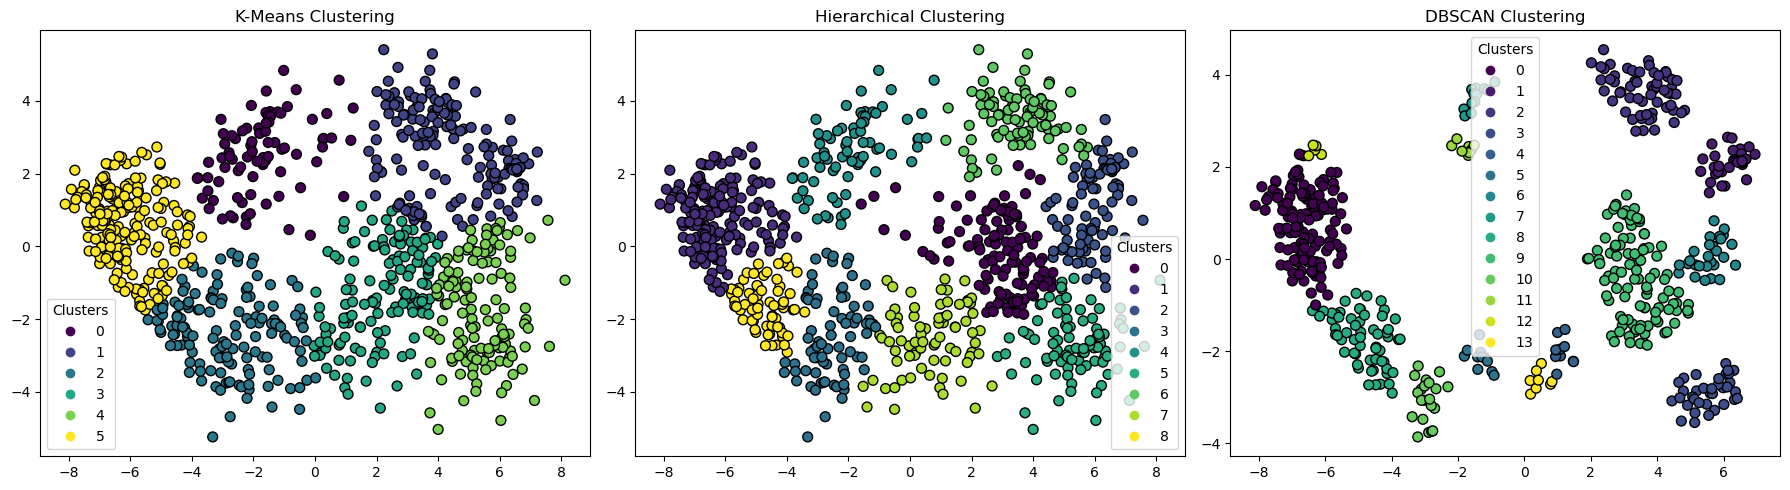

In [181]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, homogeneity_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Prepare the data (as per your previous code)
pivoted_data = merged_data.pivot_table(index=['navn', 'parti', 'political_position'], 
                                       columns='ID', values='answer', aggfunc='mean').reset_index()
pivoted_data = pivoted_data.fillna(0)  # Fill any missing values (e.g., with 0 or the mean response per question)
X = pivoted_data.drop(columns=['navn', 'parti', 'political_position'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_scaled)

# Plot k-distance graph for DBSCAN tuning
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances and plot
distances = np.sort(distances[:, 4], axis=0)  # Focus on the 5th nearest neighbor
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (Look for the Elbow)")
plt.xlabel("Points sorted by distance to 5th nearest neighbor")
plt.ylabel("Distance")
plt.show()

inertia = []
silhouette_scores = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow and Silhouette Scores
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Plot
ax[0].plot(K_range, inertia, 'bo-')
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Inertia")
ax[0].set_title("K-Means - Elbow Method for Optimal Clusters")

# Silhouette Score Plot
ax[1].plot(K_range, silhouette_scores, 'go-')
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("K-Means - Silhouette Scores for Optimal Clusters")

plt.tight_layout()
plt.show()

# Evaluation metrics
def evaluate_clustering(X, labels, true_labels=None):
    # Silhouette score
    silhouette_avg = silhouette_score(X, labels)
    
    # If true labels are available, compute additional metrics
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
        homogeneity = homogeneity_score(true_labels, labels)
        print(f"ARI: {ari:.4f}")
        print(f"Homogeneity: {homogeneity:.4f}")
    else:
        ari = homogeneity = None
        
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    return silhouette_avg, ari, homogeneity

# Apply K-Means and evaluate
kmeans = KMeans(n_clusters=6, random_state=0, n_init=10, init='k-means++')
kmeans_labels = kmeans.fit_predict(X_pca)
print("\nK-Means Clustering Evaluation:")
evaluate_clustering(X_pca, kmeans_labels)

# Apply Hierarchical Clustering and evaluate
hierarchical = AgglomerativeClustering(n_clusters=9)
hierarchical_labels = hierarchical.fit_predict(X_pca)
print("\nHierarchical Clustering Evaluation:")
evaluate_clustering(X_pca, hierarchical_labels)

# Dendrogram for Hierarchical Clustering
Z = linkage(X_pca, 'ward')  # 'ward' linkage minimizes variance within clusters
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Apply DBSCAN and evaluate
dbscan = DBSCAN(eps=0.42, min_samples=8) 
dbscan_labels = dbscan.fit_predict(X_pca)

# Filter out noise points for evaluation
dbscan_filtered_labels = dbscan_labels[dbscan_labels != -1]
dbscan_filtered_X = X_pca[dbscan_labels != -1]

print("\nDBSCAN Clustering Evaluation:")
# DBSCAN will not work if there are too few clusters, so make sure to evaluate only when valid clusters are formed
if len(np.unique(dbscan_filtered_labels)) > 1:
    evaluate_clustering(dbscan_filtered_X, dbscan_filtered_labels)

# Plot the Clustering Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot K-Means Clustering
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
axes[0].set_title("K-Means Clustering")
axes[0].legend(*scatter1.legend_elements(), title="Clusters")

# Plot Hierarchical Clustering
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
axes[1].set_title("Hierarchical Clustering")
axes[1].legend(*scatter2.legend_elements(), title="Clusters")

# Plot DBSCAN Clustering
scatter3 = axes[2].scatter(dbscan_filtered_X[:, 0], dbscan_filtered_X[:, 1], c=dbscan_filtered_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
axes[2].set_title("DBSCAN Clustering")
axes[2].legend(*scatter3.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()
